# Link Prediction in NetworKit

## Setup

In [2]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

In [3]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


## Choose graph

In [4]:
#testGraph, trainingGraph = linkprediction.readGraph("input/twitter_combined.edgelist", 0.3)
testGraph = readGraph("input/polblogs.graph", Format.METIS)

In [5]:
#for u, v in testGraph.edges():
#    trainingGraph.removeEdge(u, v)
#trainingGraph.numberOfEdges()

In [6]:
#properties.overview(trainingGraph)

## Create training and test set

In [7]:
trainingGraph = linkprediction.TrainingGraphGenerator.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 11700 / 16715


In [8]:
missingLinks = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
print("2-hop missing links in training graph:", len(missingLinks))

2-hop missing links in training graph: 149188


## Create link predictor instances

In [9]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 10)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = linkprediction.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [10]:
linkPredictors = (commonNeighborsIndex, preferentialAttachmentIndex, jaccardIndex, adamicAdarIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [11]:
positiveInstances = trainingGraph.randomEdges(25000)
negativeInstances = []
while len(negativeInstances) < 25000:
    u = trainingGraph.randomNode()
    v = trainingGraph.randomNode()
    if (u != v and not (testGraph.hasEdge(u, v) or testGraph.hasEdge(u, v)) and not (trainingGraph.hasEdge(u, v) or trainingGraph.hasEdge(u, v)) and trainingGraph.degree(u) > 0 and trainingGraph.degree(v) > 0):
        negativeInstances.append((u, v))
allInstances = positiveInstances + negativeInstances
random.shuffle(allInstances)
allInstances = np.array(allInstances)

nodePairsTrain = allInstances[:40000]
nodePairsTest = allInstances[-10000:]
classesTest = linkprediction.getClasses(nodePairsTest, trainingGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [12]:
#allMissing = []
#for i in range(0, trainingGraph.numberOfNodes()):
#    for j in range(i + 1, trainingGraph.numberOfNodes()):
#        if not trainingGraph.hasEdge(i, j) and not trainingGraph.hasEdge(j, i):
#            allMissing.append((i, j))

## Evaluation

In [13]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [14]:
dtc = ensemble.AdaBoostClassifier()
linkprediction.trainClassifier(nodePairsTrain, trainingGraph, dtc, *linkPredictors)

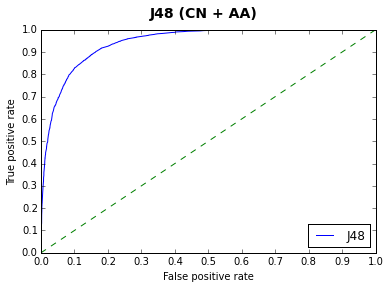

In [15]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [16]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.94431921241716044

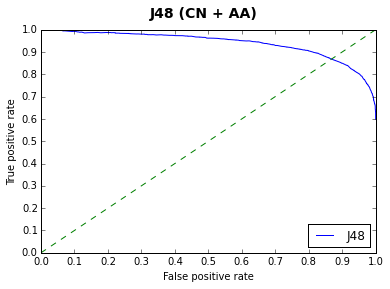

In [17]:
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(recall, precision, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [18]:
pr.getAreaUnderCurve((recall, precision))

0.9395545225556463

In [19]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.13233137130737305 seconds


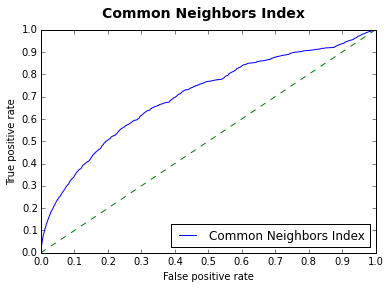

In [20]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [21]:
roc.getAreaUnderCurve()

0.7042615830924643

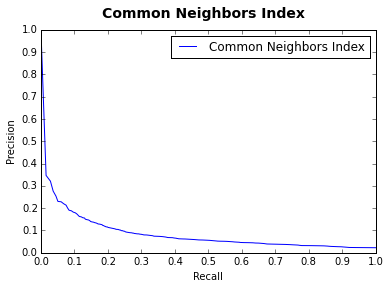

In [22]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.legend(handles=[curve])

In [23]:
pr.getAreaUnderCurve()

0.08672952400985814

In [24]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.23077130317687988 seconds


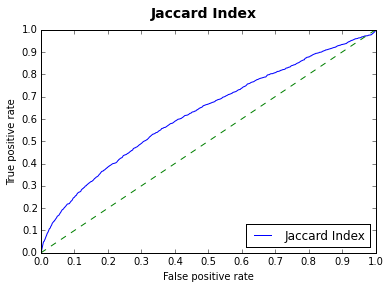

In [25]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [26]:
roc.getAreaUnderCurve()

0.6265584842196678

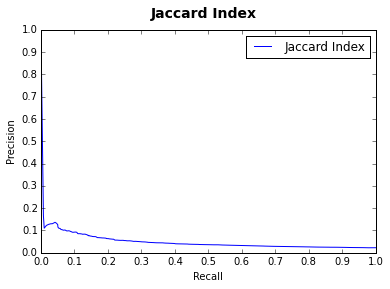

In [27]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.legend(handles=[curve])

In [28]:
pr.getAreaUnderCurve()

0.050463155153246064

In [29]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.09763741493225098 seconds


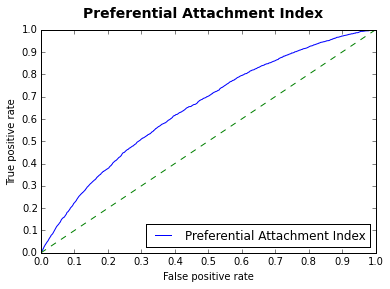

In [30]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [31]:
roc.getAreaUnderCurve()

0.6504356384317046

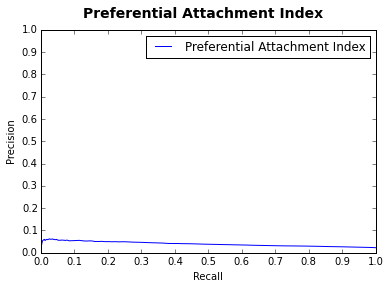

In [32]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [33]:
pr.getAreaUnderCurve()

0.040341940571685046

In [34]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.1564176082611084 seconds


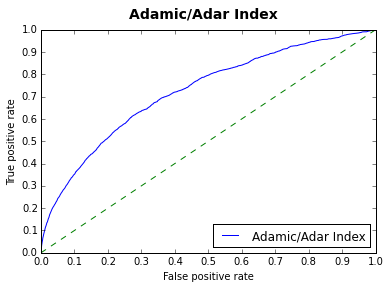

In [35]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [36]:
roc.getAreaUnderCurve()

0.7239129242564915

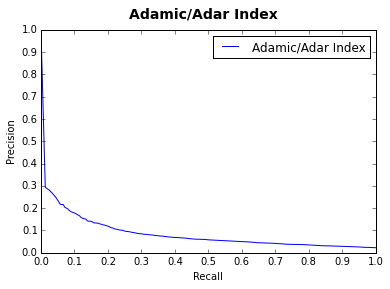

In [37]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [38]:
pr.getAreaUnderCurve()

0.0862425486133156

In [39]:
startTime = time.time()
predictions = uDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.06879210472106934 seconds


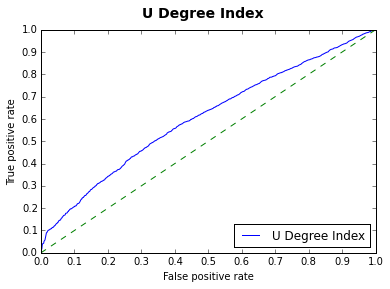

In [40]:
X, Y = roc.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [41]:
roc.getAreaUnderCurve()

0.604972234172228

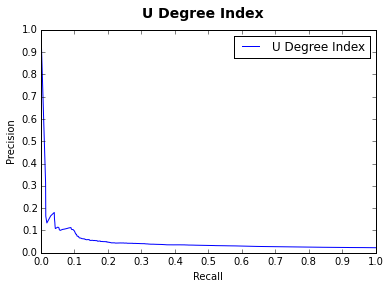

In [42]:
X, Y = pr.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.legend(handles=[curve])

In [43]:
pr.getAreaUnderCurve()

0.050861382231409166

In [44]:
startTime = time.time()
predictions = vDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.11154437065124512 seconds


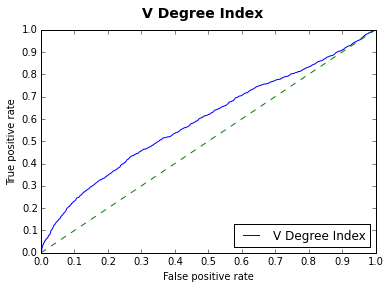

In [45]:
X, Y = roc.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [46]:
roc.getAreaUnderCurve()

0.5943287458209225

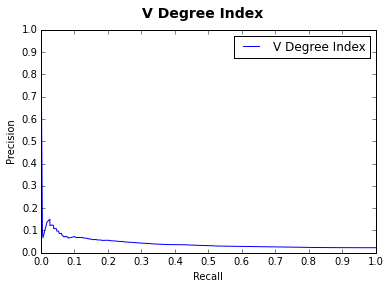

In [47]:
X, Y = pr.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.legend(handles=[curve])

In [48]:
pr.getAreaUnderCurve()

0.04295636495117786

In [49]:
startTime = time.time()
algebraicDistanceIndex.preprocess()
predictions = algebraicDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.06045389175415039 seconds


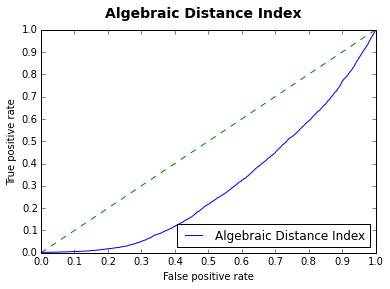

In [50]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [51]:
roc.getAreaUnderCurve()

0.3017150771606124

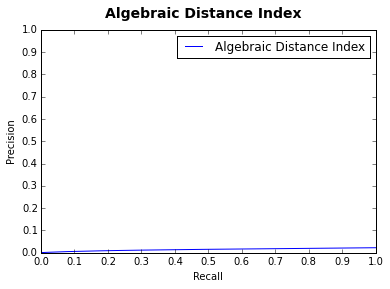

In [52]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.legend(handles=[curve])

In [53]:
pr.getAreaUnderCurve()

0.015053501282068327

In [54]:
startTime = time.time()
predictions = neighborhoodDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.1542508602142334 seconds


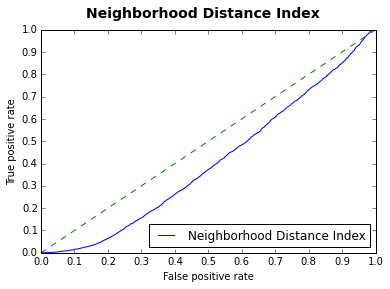

In [55]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [56]:
roc.getAreaUnderCurve()

0.403886047123907

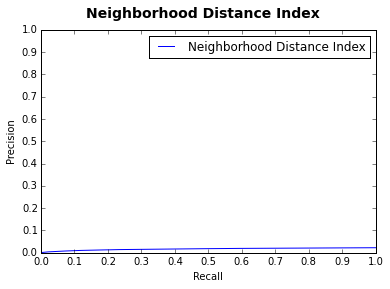

In [57]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.legend(handles=[curve])

In [58]:
pr.getAreaUnderCurve()

0.017166277528520787

In [59]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [60]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [61]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [62]:
startTime = time.time()
predictions = katzIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

3.2901723384857178 seconds


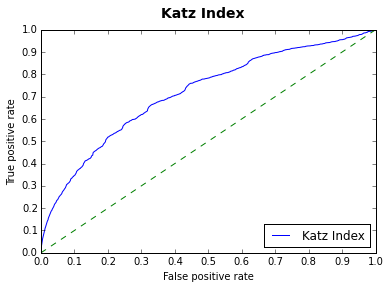

In [63]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [64]:
roc.getAreaUnderCurve()

0.7156587455733304

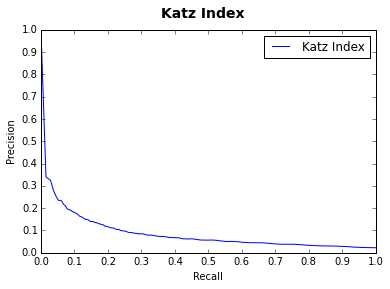

In [65]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [66]:
pr.getAreaUnderCurve()

0.08779806543534989

In [67]:
startTime = time.time()
predictions = totalNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.13825058937072754 seconds


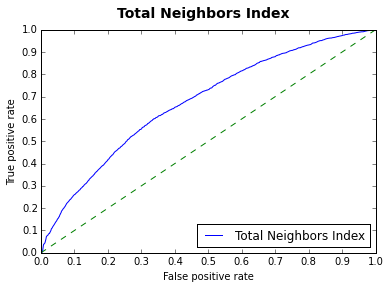

In [68]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [69]:
roc.getAreaUnderCurve()

0.6751467124889603

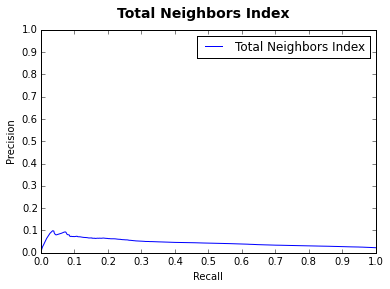

In [70]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.legend(handles=[curve])

In [71]:
pr.getAreaUnderCurve()

0.046358109309581376

In [72]:
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

3.0561559200286865 seconds


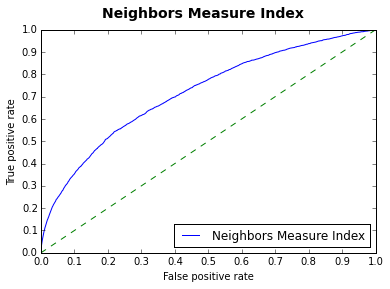

In [73]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [74]:
roc.getAreaUnderCurve()

0.7178868678044932

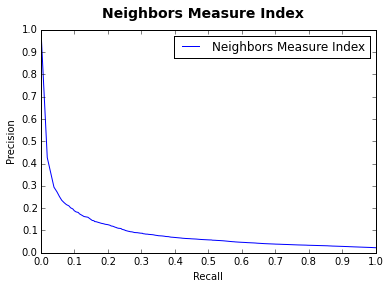

In [75]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.legend(handles=[curve])

In [76]:
pr.getAreaUnderCurve()

0.09329007418241538